C:\Users\lx\AppData\Local\Temp\ipykernel_2376\1790861996.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


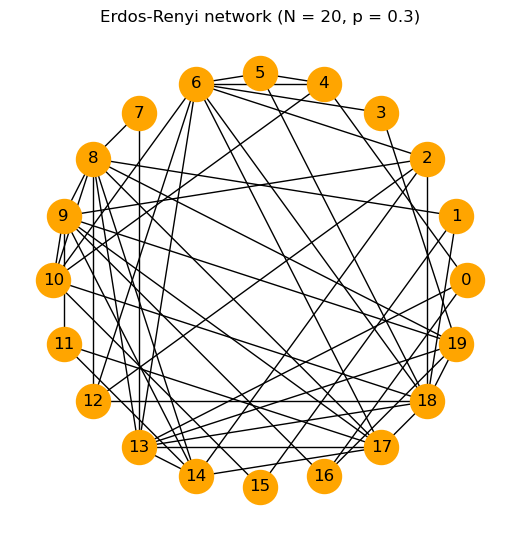

iter 5000/20000, max L1 error = 3.7194
iter 10000/20000, max L1 error = 3.2836
iter 15000/20000, max L1 error = 3.0198
iter 20000/20000, max L1 error = 2.8313


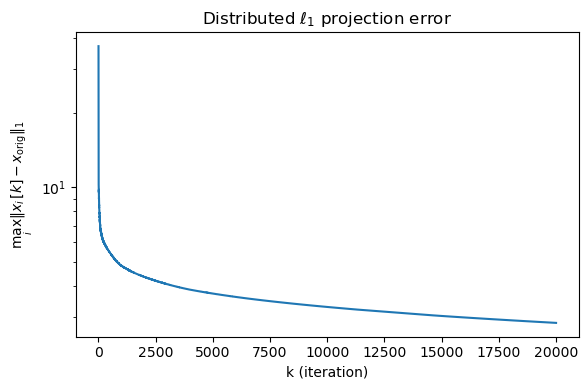

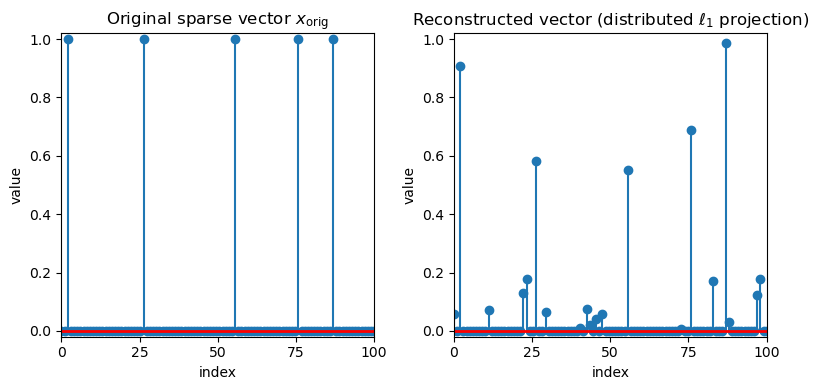

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ================== 基本参数 ==================
np.random.seed(0)

n = 100      # 向量维度
m = 20       # 群体检测次数
N = m        # 智能体数量 N = m = 20
p_edge = 0.3 # Erdős–Rényi 图的连边概率

# 迭代次数
MAX_ITERS = 20000

# 步长：相对书里的 100/(1+k) 做了“温和化”处理，避免误差一开始往上冲
def stepsize(k):
    # 一开始 alpha 比较小，之后慢慢减小
    return 0.5 / (5.0 + k)


# ================== 1. 构造原始稀疏向量 x_orig ==================
# 二值随机向量，其中 5 个元素为 1，其余为 0
x_orig = np.zeros(n)
nz_idx = np.random.choice(n, size=5, replace=False)
x_orig[nz_idx] = 1.0


# ================== 2. 构造群体检测矩阵 A 和观测 y ==================
# 0-1 随机矩阵 A，表示每次检测覆盖的对象
A = (np.random.rand(m, n) < 0.25).astype(float)  # 覆盖概率 0.25

# 防止某一行全 0（否则 a_i^T a_i = 0，无法投影）
for i in range(m):
    if A[i].sum() == 0:
        A[i, np.random.randint(0, n)] = 1.0

# 观测值 y = A x_orig（每次检测中的“阳性人数”）
y = A @ x_orig

# 第 i 个智能体本地保存 a_i, y_i
a_rows = [A[i].copy() for i in range(N)]
y_vals = [y[i].copy() for i in range(N)]


# ================== 3. 构造 Erdős–Rényi 网络 & 权重矩阵 P ==================
G = nx.erdos_renyi_graph(N, p_edge, seed=0)

# 图：分布式次梯度投影的网络
plt.figure(figsize=(5, 5))
pos = nx.circular_layout(G)  # 环形布局
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="orange",
    node_size=600,
    edge_color="black",
    width=1.0,
)
plt.title("Erdos-Renyi network (N = 20, p = 0.3)")
plt.tight_layout()
plt.show()

# 权重矩阵 P：每个节点 i 对邻居（含自己）平均取权重
P = np.zeros((N, N))
for i in range(N):
    neighbors = list(G.neighbors(i))
    neighbors.append(i)            # 把自己也算邻居
    deg_i = len(neighbors)
    for j in neighbors:
        P[i, j] = 1.0 / deg_i


# ================== 4. 分布式 ℓ1 次梯度投影算法 ==================
def sign_subgradient(x):
    """
    ℓ1 范数的次梯度：
      x_i > 0 ->  1
      x_i < 0 -> -1
      x_i = 0 ->  0  (这里取 0)
    x 的形状可以是 (N, n)
    """
    g = np.sign(x)
    g[x == 0] = 0.0
    return g

# 初始化：每个智能体从 [0,1] 区间的随机向量开始
# 这样一开始的 L1 误差比较大，之后整体是往下收敛的
X = np.random.rand(N, n)   # 第 i 行是智能体 i 的估计 x_i[k]
errors = []                # 记录每次迭代 max_i ||x_i[k] - x_orig||_1

for k in range(MAX_ITERS):
    alpha_k = stepsize(k)

    # 共识 + 次梯度: v_i[k] = sum_j p_ij x_j[k] - alpha_k * sign(x_i[k])
    V = P @ X
    V = V - alpha_k * sign_subgradient(X)

    # 投影到局部约束 a_i^T x = y_i 上
    X_new = np.zeros_like(X)
    for i in range(N):
        a_i = a_rows[i]          # (n,)
        y_i = y_vals[i]          # 标量
        v_i = V[i]               # (n,)

        denom = float(a_i @ a_i) # a_i^T a_i
        if denom < 1e-12:
            X_new[i] = v_i
        else:
            residual = y_i - a_i @ v_i
            X_new[i] = v_i + (residual / denom) * a_i

    X = X_new

    # 记录误差：对所有智能体取最大 L1 误差
    l1_errors = np.linalg.norm(X - x_orig[None, :], ord=1, axis=1)
    errors.append(l1_errors.max())

    if (k + 1) % 5000 == 0:
        print(f"iter {k+1}/{MAX_ITERS}, max L1 error = {errors[-1]:.4f}")


# ================== 5. 误差曲线（类似图 6.12） ==================
plt.figure(figsize=(6, 4))
plt.plot(range(1, MAX_ITERS + 1), errors)
plt.yscale("log")   # 纵轴取对数刻度
plt.xlabel("k (iteration)")
plt.ylabel(r"$\max_i \|x_i[k] - x_{\mathrm{orig}}\|_1$")
plt.title("Distributed $\\ell_1$ projection error")
plt.tight_layout()
plt.show()


# ================== 6. 图 6.13：原始向量 vs 重构向量 ==================
# 横坐标按 [0, 100] 区间均匀映射，和书上的刻度形式一致
x_axis = np.linspace(0, 100, n)

# 选一个智能体（例如 0 号）画出最后的估计
agent_id = 0
x_est = X[agent_id]

# 为了画图好看，把极小的负数截断到 0，上界略放宽一点
x_est_plot = np.clip(x_est, 0.0, 1.2)

plt.figure(figsize=(8, 4))

# -------- 左图：原始稀疏向量 --------
plt.subplot(1, 2, 1)
markerline, stemlines, baseline = plt.stem(
    x_axis, x_orig,
    linefmt='C0-', markerfmt='o', basefmt='r-'
)
baseline.set_linewidth(2.0)

plt.ylim(-0.02, 1.02)
plt.xlim(0, 100)
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel("index")
plt.ylabel("value")
plt.title(r"Original sparse vector $x_{\mathrm{orig}}$")

# -------- 右图：分布式投影重构向量 --------
plt.subplot(1, 2, 2)
markerline2, stemlines2, baseline2 = plt.stem(
    x_axis, x_est_plot,
    linefmt='C0-', markerfmt='o', basefmt='r-'
)
baseline2.set_linewidth(2.0)

plt.ylim(-0.02, 1.02)
plt.xlim(0, 100)
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel("index")
plt.ylabel("value")
plt.title(r"Reconstructed vector (distributed $\ell_1$ projection)")

plt.tight_layout()
plt.show()
